# Hypothesis Testing with Insurance Data (Core)


In [93]:
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import scipy
scipy.__version__

'1.8.1'

In [94]:
df = pd.read_csv('insurance - insurance.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Q1. Do smokers have higher insurance charges than non-smokers?

### 1. State your Null Hypothesis and Alternative Hypothesis
* **Null Hypothesis:** Smokers are charged the same for insurance as non-smokers
* **Alternate Hypothesis:** Smokers get charged significantly higher than non-smokers

### 2. Select the correct test according to the data type and number of samples
* Type of Data? numerical since our target feature is charges
* How many groups/samples? two groups
* Therefore, which test is appropriate? We will try using ANOVA since its great for handling numerical data between two groups

In [95]:
## Create groups dictionary. There are only 2 groups, but this is even more helpful when there are many groups
groups = {}
## Loop through all unique categories
for i in df['smoker'].unique():
    ## Get series for group and rename
    data = df.loc[df['smoker']==i,'charges'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['yes', 'no'])

### 3. Test the assumptions of your selected test
* Normality
* Equal Variance

In [96]:
## Saving JUST the numeric col as final group variables
smoker_group = df['smoker']=='yes'
non_smoker_group = df['smoker']=='no'

### Run normality test

In [97]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
yes,274.0,5.564931e-14,61.039414
no,1064.0,1.919313e-69,316.452808


In [98]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
yes,274.0,5.564931e-14,61.039414,True
no,1064.0,1.919313e-69,316.452808,True


### Test equal variance

In [99]:
# with the * operator 
result = stats.levene(*groups.values())
result.pvalue <0.05

True

In [100]:
# Use an if-ele to help interpret the p-value
if result.pvalue <.05:
    print('The groups DO NOT have equal variance')
else:
    print('The groups DO have equal variance')

The groups DO NOT have equal variance


The variance is not equal

In [101]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
#values = df['charges']
#labels = df['smoker']

### 4. Execute the selected test, or the alternative test (if you do not meet the assumptions)

In [102]:
result = stats.ttest_ind(smoker_group,non_smoker_group,equal_var=False)
result

Ttest_indResult(statistic=-37.82959586208586, pvalue=3.3179147254957174e-251)

### 5. Interpret your p-value and reject or fail to reject your null hypothesis 

In [103]:
## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,-988.8091,0.7245,-3428.9343,1451.3161,False
northeast,southeast,1329.0269,0.4745,-1044.9417,3702.9955,False
northeast,southwest,-1059.4471,0.6792,-3499.5723,1380.6781,False
northwest,southeast,2317.8361,0.0583,-54.1994,4689.8716,False
northwest,southwest,-70.638,0.9999,-2508.8826,2367.6066,False
southeast,southwest,-2388.4741,0.0477,-4760.5096,-16.4386,True


According to the turkey test I am to reject null hypothesis

### 6. Show a supporting visualization that helps display the result

In [104]:
sample = df.sample(n=50,random_state=42)
smokers = sample.loc[ sample['smoker']=='yes',"charges"]
non_smokers = sample.loc[ sample['smoker']=='no',"charges"]
## Getting means for smokers and non smokers
print(f"For smokers (n={len(smokers)}): Mean={np.mean(smokers):.2f}")
print(f"For non-smokers (n={len(non_smokers)}): Mean={np.mean(non_smokers):.2f}")

For smokers (n=11): Mean=35439.40
For non-smokers (n=39): Mean=7309.48


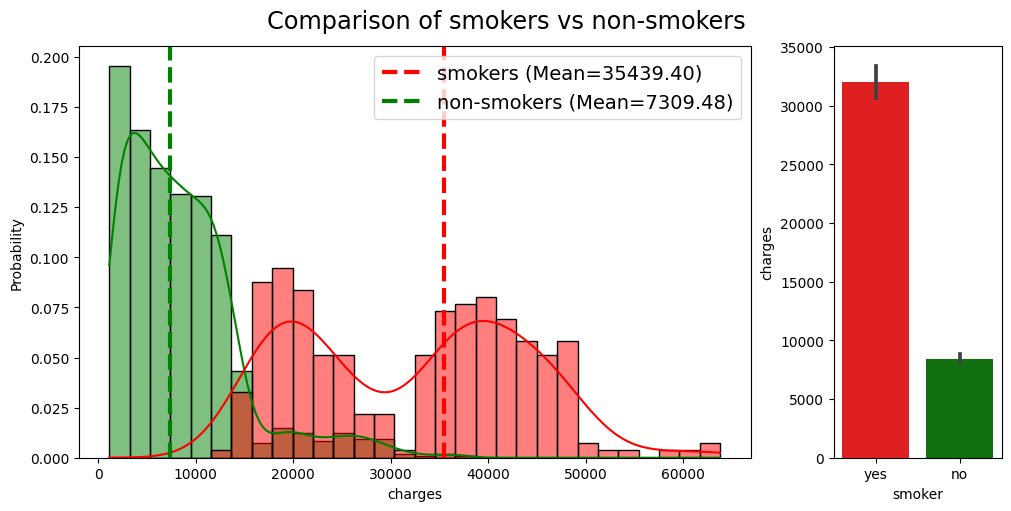

In [105]:
smoker_palette={'yes':'red', 'no':'green'}
## Visualizing Sample means
fig, (ax,ax_bar) = plt.subplots(figsize= (10,5), ncols=2, 
                                constrained_layout=True,
                                gridspec_kw={'width_ratios':[0.8,0.2]})


# Histogram
ax = sns.histplot(data=df, x='charges',hue='smoker', fill=True,kde=True,
                  stat='probability',common_norm=False,ax=ax,
                  palette=smoker_palette)

ax.axvline(np.mean(smokers), ls='--',lw=3, 
           label=f"smokers (Mean={np.mean(smokers):.2f})",color=smoker_palette['yes'])

ax.axvline(np.mean(non_smokers), ls='--', lw=3, 
           label=f"non-smokers (Mean={np.mean(non_smokers):.2f})",color=smoker_palette['no'])

ax.legend(prop={"size":14}, loc='upper right')#bbox_to_anchor=[1,1])
## Barplot
sns.barplot(data=df, x='smoker',y='charges',ax = ax_bar,palette=smoker_palette)
fig.suptitle('Comparison of smokers vs non-smokers',fontsize='xx-large');

**We can see from our final testing and visualization that the alternate hypothesis was correct and smokers are charged significantly higher insurance than non-smokers.**

## Q2. Are men more likely to smoke than women?


### 1. State your Null Hypothesis and Alternative Hypothesis
* **Null Hypothesis:** Men and women are likely to smoke equally
* **Alternate Hypothesis:** Men smoke considerably more than woman

### 2. Select the correct test according to the data type and number of samples
* Type of Data? Categorical
* How many groups/samples? 2
* Therefore, which test is appropriate? we will use Chi-squared testing since its perfect for these kinds of categorical data

In [106]:
df['sex'].value_counts()

male      676
female    662
Name: sex, dtype: int64

In [107]:
df['has_female'] = df['sex'].str.contains('female')
df['has_female'].value_counts(normalize=True)

False    0.505232
True     0.494768
Name: has_female, dtype: float64

In [108]:
needed_cols = ['has_female','smoker']
needed_cols

['has_female', 'smoker']

### 3. Test the assumptions of your selected test

In [109]:
male_df = df.loc[df['has_female']==False, needed_cols]
male_df

,has_female,smoker
1,False,no
2,False,no
3,False,no
4,False,no
8,False,no
...,...,...
1324,False,no
1325,False,no
1327,False,no
1329,False,no


In [110]:
female_df = df.loc[df['has_female']==True, needed_cols]
female_df

,has_female,smoker
0,True,yes
5,True,no
6,True,no
7,True,no
9,True,no
...,...,...
1332,True,no
1334,True,no
1335,True,no
1336,True,no


### 4. Execute the selected test, or the alternative test (if you do not meet the assumptions)

In [111]:
# calculate the contingency table with pd.cross-tab
table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [112]:
# Run the Test and Save the Output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result #this labels the results

### 5. Interpret your p-value and reject or fail to reject your null hypothesis 

In [113]:
# What was our p-value?
print(p)
p<.05

0.006548143503580696


True

**Since our p < .05, we reject the null hypothesis that there is no relationship between a persons sex and if they smoked.**

**This means that we accept the alternate hypothesis and conclude that males are more likely to smoke**

### 6. Show a supporting visualization that helps display the result

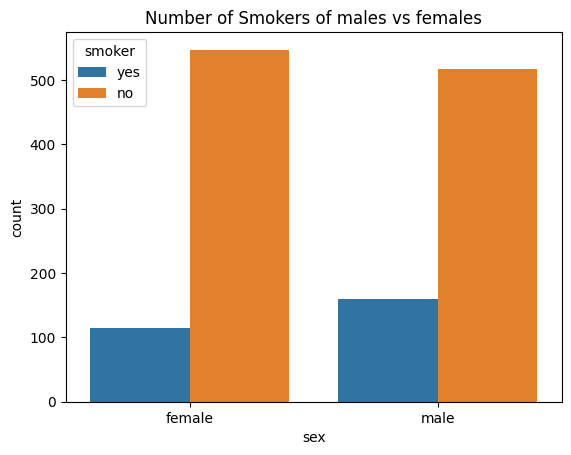

In [114]:
ax = sns.countplot(data=df, x='sex',hue='smoker',)
ax.set_title("Number of Smokers of males vs females");

**According to the visualization, since we do not have an equal variance, this means that males are more likely to smoke.**

## Q3. Do different regions have different charges, on average?


### 1. State your Null Hypothesis and Alternative Hypothesis
* **Null Hypothesis:** Region all charge the same on average
* **Alternate Hypothesis:** Some regions charge more on average than others

In [115]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

### 2. Select the correct test according to the data type and number of samples
* Type of Data? Numerical feature since we are targeting charges
* How many groups/samples? there are 4 groups
* Therefore, which test is appropriate? We will be using ANOVA since its perfect for handling groups more than two

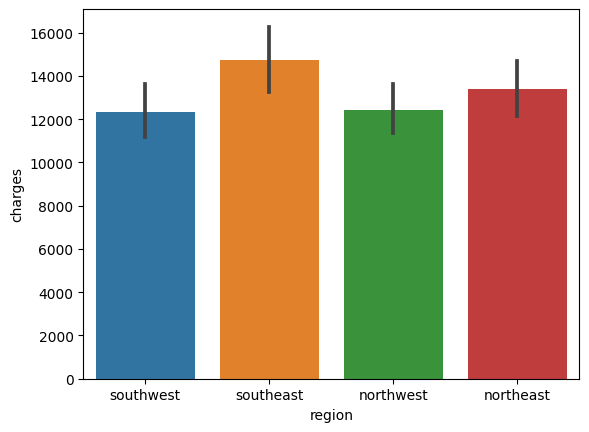

In [116]:
sns.barplot(data=df, x='region',y='charges');

### 3. Test the assumptions of your selected test

In [117]:
## Create groups dictionary. There are only 4 groups, but this is even more helpful when there are many groups
groups = {}
## Loop through all unique categories
for i in df['region'].unique():
    ## Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

### Testing Normality

In [118]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df


,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


In [119]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


Each group has a different distribution

### Testing Assumption of Equal Variance

In [120]:
# with the * operator 
stats.levene(*groups.values())

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

We did not meet the assumption on equal variance

### 4. Execute the selected test, or the alternative test (if you do not meet the assumptions)

In [121]:
# perform the correct hypothesis test
# note again the use of the * operator for convenience
result2 = stats.f_oneway( *groups.values())
result2

F_onewayResult(statistic=2.96962669358912, pvalue=0.0308933560705201)

### 5. Interpret your p-value and reject or fail to reject your null hypothesis 

In [122]:
# with the * operator 
result2 = stats.levene(*groups.values())
result2.pvalue <0.05

True

In [123]:
# Use an if-ele to help interpret the p-value
if result.pvalue <.05:
    print('The groups DO NOT have equal variance')
else:
    print('The groups DO have equal variance')

AttributeError: 'tuple' object has no attribute 'pvalue'

### 6. Show a supporting visualization that helps display the result

In [124]:
sample2 = df.sample(n=50,random_state=42)
southwest = sample2.loc[ sample2['region']=='southwest',"charges"]
southeast = sample2.loc[ sample2['region']=='southeast',"charges"]
northwest = sample2.loc[ sample2['region']=='northwest',"charges"]
northeast = sample2.loc[ sample2['region']=='northeast',"charges"]
## Getting means for region charges
print(f"For southwest (n={len(southwest)}): Mean={np.mean(southwest):.2f}")
print(f"For southeast (n={len(southeast)}): Mean={np.mean(southeast):.2f}")
print(f"For northwest (n={len(northwest)}): Mean={np.mean(northwest):.2f}")
print(f"For northeast (n={len(northeast)}): Mean={np.mean(northeast):.2f}")

For southwest (n=14): Mean=7926.70
For southeast (n=13): Mean=22870.58
For northwest (n=17): Mean=13114.17
For northeast (n=6): Mean=7278.48


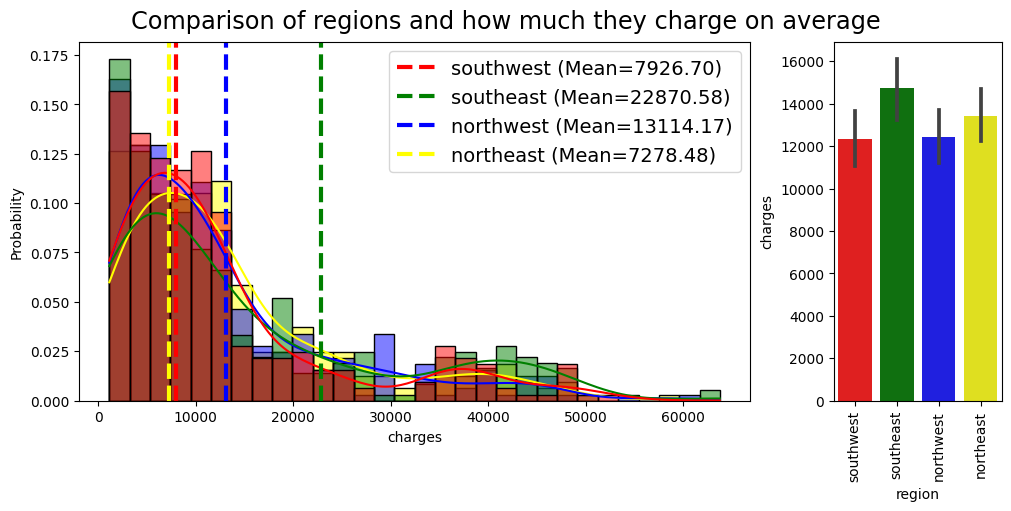

In [125]:
region_palette={'southwest':'red', 'southeast':'green','northwest':'blue','northeast':'yellow'}
## Visualizing Sample means
fig, (ax,ax_bar) = plt.subplots(figsize= (10,5), ncols=2, 
                                constrained_layout=True,
                                gridspec_kw={'width_ratios':[0.8,0.2]})


# Histogram
ax = sns.histplot(data=df, x='charges',hue='region', fill=True,kde=True,
                  stat='probability',common_norm=False,ax=ax,
                  palette=region_palette)

ax.axvline(np.mean(southwest), ls='--',lw=3, 
           label=f"southwest (Mean={np.mean(southwest):.2f})",color=region_palette['southwest'])

ax.axvline(np.mean(southeast), ls='--', lw=3, 
           label=f"southeast (Mean={np.mean(southeast):.2f})",color=region_palette['southeast'])

ax.axvline(np.mean(northwest), ls='--',lw=3, 
           label=f"northwest (Mean={np.mean(northwest):.2f})",color=region_palette['northwest'])

ax.axvline(np.mean(northeast), ls='--', lw=3, 
           label=f"northeast (Mean={np.mean(northeast):.2f})",color=region_palette['northeast'])

ax.legend(prop={"size":14}, loc='upper right')#bbox_to_anchor=[1,1])
## Barplot
sns.barplot(data=df, x='region',y='charges',ax = ax_bar,palette=region_palette)
plt.xticks(rotation=90)
fig.suptitle('Comparison of regions and how much they charge on average',fontsize='xx-large');

**According to the data, we do not have an equal distribution and normal p value so this means that regions are charged more depending on their location.**